# NESTML dopamine-modulated STDP synapse tutorial

<i>Some text in this this notebook is copied verbatim from [1]. Network diagrams were modeled after [2].</i>

Pavlov and Thompson (1902) first described classical conditioning: a phenomenon in which a biologically potent stimulus–the Unconditional Stimulus (UC)—is initially paired with a neutral stimulus—the Conditional Stimulus (CS). After many trials, learning is observed when the previously neutral stimuli start to elicit a response similar to that which was previously only elicited by the biologically potent stimulus. Pavlov and Thompson performed many experiments with dogs, observing their response (by monitoring salivation) to the appearance of a person who has been feeding them and the actual food appearing (UC). He demonstrated that the dogs started to salivate in the presence of the person who has been feeding them (or any other CS), rather than just when the food appears, because the CS had previously been associated with food.

<center> 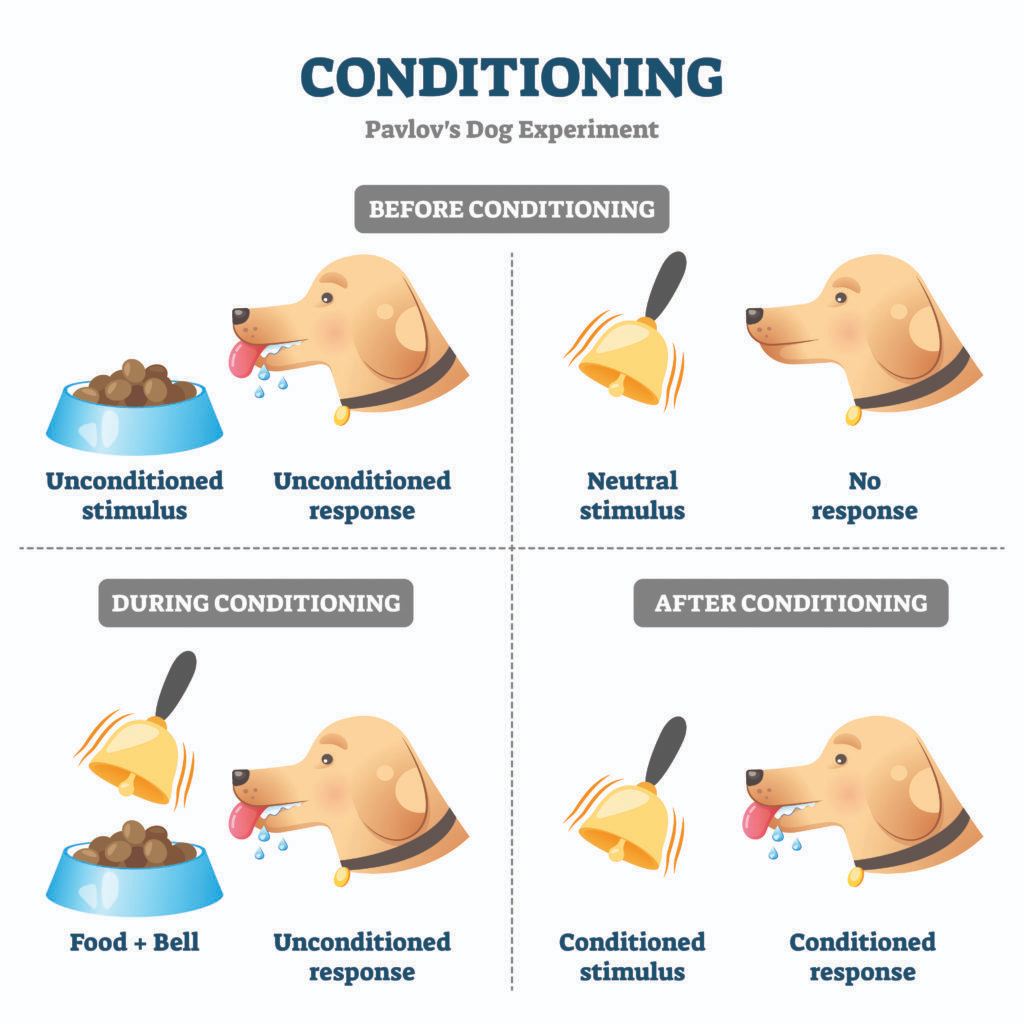 </center>

<i> <center> Image credits: https://www.psychologicalscience.org/observer/revisiting-pavlovian-conditioning </center> </i>


In this tutorial, a dopamine-modulated STDP model is created in NESTML, and we characterize the model before using it in a network (reinforcement) learning task.


## Model

Izhikevich (2007) revisits an important question: how does an
animal know which of the many cues and actions preceding a
reward should be credited for the reward? Izhikevich explains
that dopamine-modulated STDP has a built-in instrumental
conditioning property, i.e., the associations between cues, actions and rewards are learned automatically by reinforcing the firing patterns (networks of synapses) responsible, even when the firings of those patterns are followed by a delayed reward or masked by other network activity.

To achieve this, each synapse has an eligibility trace $C$:

$$
\frac{dC}{dt} = -\frac{C}{\tau_C} + \text{STDP}(\Delta t)\delta(t - t_\text{pre/post}) \quad \text{(1)}
$$

where $\tau_C$ is the decay time constant of the eligibility trace and $\text{STDP}(\Delta t)$ represents the magnitude of the change to make to the eligibility trace in response to a pair of pre- and post-synaptic spikes with temporal difference $\Delta t = t_\text{post} − t_\text{pre}$. (This is just the usual STDP rule, see https://nestml.readthedocs.io/en/latest/tutorials/stdp_windows/stdp_windows.html.) Finally, $\delta(t − t_\text{pre/post})$ is a Dirac delta function used to apply the effect of STDP to the trace at the times of pre- or post-synaptic spikes.

The concentration of dopamine is described by a variable $D$:

$$
\frac{dD}{dt} = − \frac{D}{\tau_d} + D_c \sum_{t_d^f} \delta(t - t_d^f) \quad \text{(2)}
$$

where $\tau_d$ is the time constant of dopamine re-absorption, $D_c$ is a real number indicating the increase in dopamine concentration caused by each incoming dopaminergic spike; $t_d^f$ are the times of these spikes.

Equations (1, 2) are then combined to calculate the change in
synaptic strength $W$:

$$
\frac{dW}{dt} = CD  \quad \text{(3)}
$$

When a post-synaptic spike arrives very shortly after a pre-synaptic spike, a standard STDP rule would immediately potentiate the synaptic strength. However, when using the three-factor STDP rule, this potentiation would instead be applied to the eligibility trace.

Because changes to the synaptic strength are gated by dopamine concentration $D$ (Equation 3), changes are only made to the synaptic strength if $D \neq 0$. Furthermore, if the eligibility trace has decayed back to 0 before any dopaminergic spikes arrive, the synaptic strength will also not be changed.

In [1]:
%matplotlib inline

from typing import List, Optional

import matplotlib as mpl

mpl.rcParams['axes.formatter.useoffset'] = False
mpl.rcParams['axes.grid'] = True
mpl.rcParams['grid.color'] = 'k'
mpl.rcParams['grid.linestyle'] = ':'
mpl.rcParams['grid.linewidth'] = 0.5
mpl.rcParams['figure.dpi'] = 120
mpl.rcParams['figure.figsize'] = [8., 3.]

import matplotlib.pyplot as plt
import nest
import numpy as np
import os
import random
import re

from pynestml.codegeneration.nest_code_generator_utils import NESTCodeGeneratorUtils

## Generating code with NESTML

To generate fast code, NESTML needs to process the synapse model together with the neuron model that will be its postsynaptic partner in the network instantiantion (see https://nestml.readthedocs.io/en/latest/nestml_language/synapses_in_nestml.html#generating-code).

In this tutorial, we will use a very simple integrate-and-fire model, where arriving spikes cause an instantaneous increment of the membrane potential, the "iaf_psc_delta" model.

We first define a helper function to generate the C++ code for the models, build it as a NEST extension module, and load the module into the kernel. The resulting model names are composed of associated neuron and synapse partners, because of the co-generation, for example, "stdp_synapse__with_iaf_psc_delta" and "iaf_psc_delta__with_stdp_synapse".

Because NEST does not support un- or reloading of modules at the time of writing, we implement a workaround that appends a unique number to the name of each generated model, for example, "stdp_synapse_3cc945f__with_iaf_psc_delta_3cc945f" and "iaf_psc_delta_3cc945f__with_stdp_synapse_3cc945f".

The resulting neuron and synapse model names are returned by the function, so we do not have to think about these internals.

### Formulating the model in NESTML

We now go on to define the full synapse model in NESTML:

In [2]:
nestml_stdp_dopa_model = """
synapse neuromodulated_stdp:

    state:
        w real = 1.
        n real = 0.   # Neuromodulator concentration
        c real = 0.   # Eligibility trace
        pre_tr real = 0.
        post_tr real = 0.

    parameters:
        d ms = 1 ms  @nest::delay
        tau_tr_pre ms = 20 ms   # STDP time constant for weight changes caused by pre-before-post spike pairings.
        tau_tr_post ms = 20 ms    # STDP time constant for weight changes caused by post-before-pre spike pairings.
        tau_c ms = 1000 ms    # Time constant of eligibility trace
        tau_n ms = 200 ms   # Time constant of dopaminergic trace
        b real = 0.   # Dopaminergic baseline concentration
        Wmax real = 200.    # Maximal synaptic weight
        Wmin real = 0.    # Minimal synaptic weight
        A_plus real = 1.    # Multiplier applied to weight changes caused by pre-before-post spike pairings. If b (dopamine baseline concentration) is zero, then A_plus is simply the multiplier for facilitation (as in the stdp_synapse model). If b is not zero, then A_plus will be the multiplier for facilitation only if n - b is positive, where n is the instantenous dopamine concentration in the volume transmitter. If n - b is negative, A_plus will be the multiplier for depression.
        A_minus real = 1.5    # Multiplier applied to weight changes caused by post-before-pre spike pairings. If b (dopamine baseline concentration) is zero, then A_minus is simply the multiplier for depression (as in the stdp_synapse model). If b is not zero, then A_minus will be the multiplier for depression only if n - b is positive, where n is the instantenous dopamine concentration in the volume transmitter. If n - b is negative, A_minus will be the multiplier for facilitation.
        A_vt real = 1.     # Multiplier applied to dopa spikes

    equations:
        pre_tr' = -pre_tr / tau_tr_pre
        post_tr' = -post_tr / tau_tr_post

    internals:
        tau_s 1/ms = (tau_c + tau_n) / (tau_c * tau_n)

    input:
        pre_spikes 1/s <- spike
        post_spikes 1/s <- spike
        mod_spikes 1/s <- spike

    output:
        spike

    onReceive(mod_spikes):
        n += A_vt / tau_n

    onReceive(post_spikes):
        post_tr += 1.

        # facilitation
        c += A_plus * pre_tr

    onReceive(pre_spikes):
        pre_tr += 1.

        # depression
        c -= A_minus * post_tr

        # deliver spike to postsynaptic partner
        deliver_spike(w, d)

    # update from time t to t + resolution()
    update:
        # resolution() returns the timestep to be made (in units of time)
        # the sequence here matters: the update step for w requires the "old" values of c and n
        w -= c * ( n / tau_s * expm1( -tau_s * resolution() ) \
                 - b * tau_c * expm1( -resolution() / tau_c ))
        w = max(0., w)
        c = c * exp(-resolution() / tau_c)
        n = n * exp(-resolution() / tau_n)
"""

Generate the code, build the user module and make the model available to instantiate in NEST:

In [3]:
# generate and build code
module_name, neuron_model_name, synapse_model_name = NESTCodeGeneratorUtils.generate_code_for("../../../models/neurons/iaf_psc_delta.nestml",
                                                                                              nestml_stdp_dopa_model,
                                                                                              post_ports=["post_spikes"],
                                                                                              mod_ports=["mod_spikes"])

# load dynamic library (NEST extension module) into NEST kernel
nest.Install(module_name)

[7,iaf_psc_deltadb67aa5d43e64530967cc637182cd89a_nestml, WARNING, [59:8;60:8]]: Variable 'G' has the same name as a physical unit!
[8,iaf_psc_deltadb67aa5d43e64530967cc637182cd89a_nestml, WARNING, [77:8;77:26]]: Variable 'h' has the same name as a physical unit!
[13,neuromodulated_stdpdb67aa5d43e64530967cc637182cd89a_nestml, WARNING, [12:8;12:28]]: Variable 'd' has the same name as a physical unit!
[22,iaf_psc_deltadb67aa5d43e64530967cc637182cd89a_nestml, WARNING, [59:8;60:8]]: Variable 'G' has the same name as a physical unit!
[23,iaf_psc_deltadb67aa5d43e64530967cc637182cd89a_nestml, WARNING, [77:8;77:26]]: Variable 'h' has the same name as a physical unit!
[25,neuromodulated_stdpdb67aa5d43e64530967cc637182cd89a_nestml, WARNING, [12:8;12:28]]: Variable 'd' has the same name as a physical unit!
[44,iaf_psc_deltadb67aa5d43e64530967cc637182cd89a_nestml__with_neuromodulated_stdpdb67aa5d43e64530967cc637182cd89a_nestml, WARNING, [59:8;60:8]]: Variable 'G' has the same name as a physical uni

## Running the simulation in NEST

Let's define a function that will instantiate a simple network with one presynaptic cell and one postsynaptic cell connected by a single synapse, then run a simulation and plot the results.

<div style="width: 100%; transform: scale(.8)">

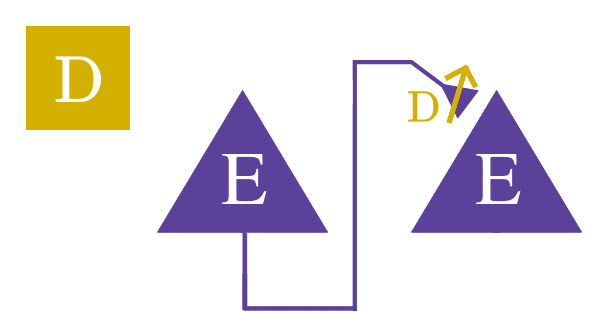
    
</div>

In [4]:
def run_network(pre_spike_time, post_spike_time, vt_spike_times,
                neuron_model_name,
                synapse_model_name,
                resolution=.1, # [ms]
                delay=1., # [ms]
                lmbda=1E-6,
                sim_time=None,  # if None, computed from pre and post spike times
                synapse_parameters=None,  # optional dictionary passed to the synapse
                fname_snip="",
                debug=False):

    #nest.set_verbosity("M_WARNING")
    nest.set_verbosity("M_ALL")

    nest.ResetKernel()
    nest.SetKernelStatus({'resolution': resolution})

    # create spike_generators with these times
    pre_sg = nest.Create("spike_generator",
                         params={"spike_times": [pre_spike_time]})
    post_sg = nest.Create("spike_generator",
                          params={"spike_times": [post_spike_time]})
    vt_sg = nest.Create("spike_generator",
                            params={"spike_times": vt_spike_times})

    # create  volume transmitter
    vt = nest.Create("volume_transmitter")
    vt_parrot = nest.Create("parrot_neuron")
    nest.Connect(vt_sg, vt_parrot)
    nest.Connect(vt_parrot, vt, syn_spec={"synapse_model": "static_synapse",
                                          "weight": 1.,
                                          "delay": 1.})   # delay is ignored!

    # set up custom synapse models
    wr = nest.Create('weight_recorder')
    nest.CopyModel(synapse_model_name, "stdp_nestml_rec",
                {"weight_recorder": wr[0],
                 "w": 1.,
                 "delay": delay,
                 "receptor_type": 0,
                 "volume_transmitter": vt,
                 "tau_tr_pre": 10.,
                })

    # create parrot neurons and connect spike_generators
    pre_neuron = nest.Create("parrot_neuron")
    post_neuron = nest.Create(neuron_model_name)
    
    spikedet_pre = nest.Create("spike_recorder")
    spikedet_post = nest.Create("spike_recorder")
    spikedet_vt = nest.Create("spike_recorder")

    #mm = nest.Create("multimeter", params={"record_from" : ["V_m"]})

    nest.Connect(pre_sg, pre_neuron, "one_to_one", syn_spec={"delay": 1.})
    nest.Connect(post_sg, post_neuron, "one_to_one", syn_spec={"delay": 1., "weight": 9999.})
    nest.Connect(pre_neuron, post_neuron, "all_to_all", syn_spec={'synapse_model': 'stdp_nestml_rec'})
    #nest.Connect(mm, post_neuron)

    nest.Connect(pre_neuron, spikedet_pre)
    nest.Connect(post_neuron, spikedet_post)
    nest.Connect(vt_parrot, spikedet_vt)
    
    # get STDP synapse and weight before protocol
    syn = nest.GetConnections(source=pre_neuron, synapse_model="stdp_nestml_rec")
    if synapse_parameters is None:
        synapse_parameters = {}
    nest.SetStatus(syn, synapse_parameters)

    initial_weight = nest.GetStatus(syn)[0]["w"]
    np.testing.assert_allclose(initial_weight, 1)
    nest.Simulate(sim_time)
    updated_weight = nest.GetStatus(syn)[0]["w"]

    actual_t_pre_sp = nest.GetStatus(spikedet_pre)[0]["events"]["times"][0]
    actual_t_post_sp = nest.GetStatus(spikedet_post)[0]["events"]["times"][0]

    pre_spike_times_ = nest.GetStatus(spikedet_pre, "events")[0]["times"]
    assert len(pre_spike_times_) == 1 and pre_spike_times_[0] > 0
    
    post_spike_times_ = nest.GetStatus(spikedet_post, "events")[0]["times"]
    assert len(post_spike_times_) == 1 and post_spike_times_[0] > 0

    vt_spike_times_ = nest.GetStatus(spikedet_vt, "events")[0]["times"]
    assert len(vt_spike_times_) == 1 and vt_spike_times_[0] > 0

    #dt = actual_t_post_sp - actual_t_pre_sp
    dt = 0.
    dw = updated_weight

    return dt, dw

In [5]:
def run_vt_spike_timing_experiment(neuron_model_name, synapse_model_name, synapse_parameters=None):
    sim_time = 10000.    # [ms] -- make sure to simulate for much longer than the eligibility trace
                         #         time constant, which is typically the slowest time constant in 
                         #         the system, PLUS the time of the latest vt spike
    pre_spike_time = 1.  # [ms]
    post_spike_time = 3. # [ms]
    delay = .5           # dendritic delay [ms]

    dt_vec = []
    dw_vec = []
    for vt_spike_time in np.round(np.linspace(4, 5000, 12)).astype(float):  # sim_time - 10 * delay
        dt, dw = run_network(pre_spike_time, post_spike_time, [vt_spike_time],
                          neuron_model_name,
                          synapse_model_name,
                          delay=delay, # [ms]
                          synapse_parameters=synapse_parameters,
                          sim_time=sim_time)
        dt_vec.append(vt_spike_time)
        dw_vec.append(dw)
        
    return dt_vec, dw_vec, delay

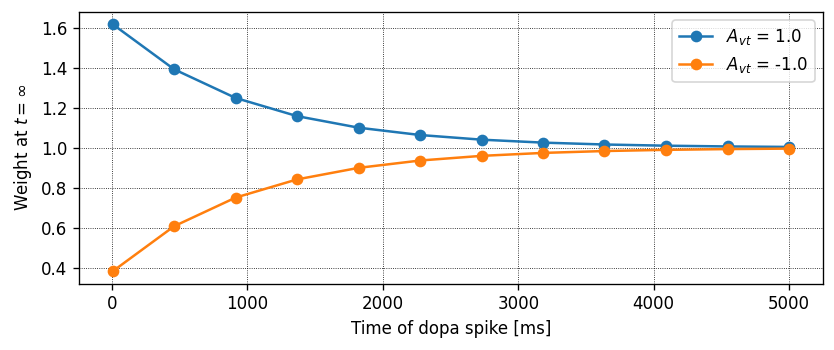

In [6]:
fig, ax = plt.subplots()
for A_vt in [1., -1.]:
    dt_vec, dw_vec, delay = run_vt_spike_timing_experiment(neuron_model_name,
                                                       synapse_model_name, 
                                                       synapse_parameters={"A_vt": A_vt})
    ax.plot(dt_vec, dw_vec, marker='o', label="$A_{vt}$ = " + str(A_vt))

ax.set_xlabel("Time of dopa spike [ms]")
ax.set_ylabel("Weight at $t = \infty$")
ax.legend()

## Learning through dopamine

In this section we simulate the spiking activity of a group of neurons with the learning rule as described above. Here, we perform the simulation on 10 `iaf_psc_delta` neurons in which each of the neurons receives input from an independent Poisson source of 50Hz. These neurons are also connected to a single dopamine spike source. These dopamine spikes are delivered to the neurons as reward and punishment signals at specific time intervals.

<div style="transform: scale(.8)">

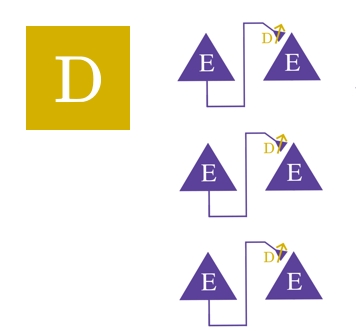

</div>

_Single dopamine source, multiple independent pre-post cell pairs (3 pairs shown)._

In [7]:
# Labels for x and y axes for traces used in plotting functions
labels = {"c": {"x_label": "Times [ms]", "y_label": "Eligibility \ntrace (c)"},
          "w": {"x_label": "Times [ms]", "y_label": "Weight \ntrace (w)"},
          "pre_tr": {"x_label": "Times [ms]", "y_label": "Presynaptic \ntrace (pre_tr)"},
          "n": {"x_label": "Times [ms]", "y_label": "Doapmine \ntrace (n)"}
         }

In [8]:
# Plot trace values for a neurons or set of neurons
def plot_traces_for_neuron(log, recordables, neuron_numbers=None, pos_dopa_spike_times=None, neg_dopa_spike_times=None):
    """
    Plots the trace values for the given list of neuron IDs
    """
    times = log["t"]
    trace_values = {}
    # Initialize the list if "neuron_numbers" is None, which corresponds to all neurons
    if neuron_numbers is None:
        neuron_numbers = np.array([i+1 for i in range(10)])

    # The actual neuron numbers are -1 of the given numbers
    neuron_numbers_actual = np.array(neuron_numbers) - 1
    
    # Get the values of recordables for the given neuron IDs
    for recordable in recordables:
        trace_values[recordable] = np.array(log[recordable])[:, neuron_numbers_actual]

    n_neurons = len(neuron_numbers)
    palette = plt.get_cmap('tab10')
    
    for i in range(n_neurons):
        fig, ax = plt.subplots(nrows=len(recordables), sharex=True, squeeze=False)
        ax = ax.flatten()
        fig.suptitle("Trace values for Neuron " + str(neuron_numbers[i]))
        for j, recordable in enumerate(recordables):
            ax[j].plot(times, trace_values[recordable][:, i], label="neuron " + str(neuron_numbers[i]), color=palette(neuron_numbers_actual[i]))
            ax[j].set_xlim(xmin=0)
            ax[j].set_ylabel(labels[recordable]["y_label"], rotation=0, ha="right", va="center")
            ax[j].legend(loc="upper right", labelspacing=0.)
            if pos_dopa_spike_times is not None:
                ax[j].scatter(pos_dopa_spike_times, np.ones_like(pos_dopa_spike_times) * np.amin(trace_values[recordable][:, i]), marker="^", c="green", s=20)
            if neg_dopa_spike_times is not None:
                ax[j].scatter(neg_dopa_spike_times, np.ones_like(neg_dopa_spike_times) * np.amin(trace_values[recordable][:, i]), marker="^", c="red", s=20)
        fig.tight_layout(rect=[0, 0.03, 1, 0.95])

In [9]:
def plot_spiking_activity(neuron_spike_times, pos_dopa_spike_times, neg_dopa_spike_times, source_ids, total_t_sim):
    fig, ax = plt.subplots()
    palette = plt.get_cmap('tab10')
    
    n_neurons = len(neuron_spike_times)
    y_ticks = [i * 10 for i in range(n_neurons, 0, -1)]
    for i in range(n_neurons):
        ax.scatter(neuron_spike_times[i], np.ones_like(neuron_spike_times[i]) * y_ticks[i], color=palette(i), s=1)

    if pos_dopa_spike_times is not None:
        ax.scatter(pos_dopa_spike_times, np.zeros_like(pos_dopa_spike_times), marker="^", c="green", s=100)
    if neg_dopa_spike_times is not None:
        ax.scatter(neg_dopa_spike_times, np.zeros_like(pos_dopa_spike_times), marker="^", c="red", s=100)

    ax.set_xlim(0., total_t_sim)
    ax.set_ylim(ymin=0)
    ax.set_xlim(xmin=0)
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(source_ids)
    ax.set_xlabel("Time [ms]")
    ax.set_ylabel("Neuron ID")
    plt.tight_layout()
    fig.show()

Here, we setup the network with 10 neurons each connected to a Poisson source. The neurons are also connected to a volume transmitter that acts as a dopamine spike source.

In [10]:
# simulation parameters
resolution = .1

# network parameters
n_neurons = 10
tau_n = 50.
tau_c = 100.
pre_poisson_rate = 50.  # [s^-1]
initial_weight = 5.6  # controls initial firing rate before potentiation

# stimulus parameters
pos_dopa_spike_times = [2000, 3000, 4000]
neg_dopa_spike_times = [8000, 9000, 10000]
A_vt = [10., -10.]


nest.set_verbosity("M_ALL")

nest.ResetKernel()
nest.SetKernelStatus({'resolution': resolution})

# Create the neurons
neurons = nest.Create(neuron_model_name, n_neurons)

# Create a poisson generator
poisson_gen = nest.Create("poisson_generator", n_neurons, params={"rate": pre_poisson_rate})
parrot_neurons = nest.Create("parrot_neuron", n_neurons)

# Spike generators
vt_sg = nest.Create("spike_generator", params={"spike_times": pos_dopa_spike_times + neg_dopa_spike_times})

# Spike recorder
spike_rec = nest.Create("spike_recorder")
spike_rec_vt = nest.Create("spike_recorder")
spike_re_pt = nest.Create("spike_recorder")

# create  volume transmitter
vt = nest.Create("volume_transmitter")
vt_parrot = nest.Create("parrot_neuron")
nest.Connect(vt_sg, vt_parrot, syn_spec={"weight": -1.})
nest.Connect(vt_parrot, vt, syn_spec={"synapse_model": "static_synapse",
                                      "weight": 1.,
                                      "delay": 1.})

# multimeters
mms = [nest.Create("multimeter", params= {"record_from": ["V_m"]}) for _ in range(n_neurons)]

# set up custom synapse models
wr = nest.Create('weight_recorder')
nest.CopyModel(synapse_model_name, "stdp_nestml_rec",
            {"weight_recorder": wr[0],
             "w": initial_weight,
             "d": delay,
             "receptor_type": 0,
             "volume_transmitter": vt,
             "tau_n": tau_n,
             "tau_c": tau_c,
            })

# Connect everything
nest.Connect(poisson_gen, parrot_neurons, "one_to_one")
nest.Connect(parrot_neurons, neurons, "one_to_one", syn_spec="stdp_nestml_rec")

nest.Connect(neurons, spike_rec)
nest.Connect(vt_parrot, spike_rec_vt)

for i in range(n_neurons):
    nest.Connect(mms[i], neurons[i])

This is a helper function that runs the simulation in chunks of time intervals and records the values of the synapse properties passed as `recordables`.

In [11]:
def run_simulation_in_chunks(sim_chunks, sim_time, recordables, neurons):
    sim_time_per_chunk = sim_time / sim_chunks

    # Init log to collect the values of all recordables
    log = {}
    log["t"] = []

    # Initialize all the arrays
    # Additional one entry is to store the trace value before the simulation begins
    for rec in recordables:
        log[rec] = (sim_chunks + 1) * [[]]

    # Get the value of trace values before the simulation
    syn = nest.GetConnections(target=neurons, synapse_model="stdp_nestml_rec")
    for rec in recordables:
        log[rec][0] = syn.get(rec)
        
    log["t"].append(nest.GetKernelStatus("biological_time"))

    # Run the simulation in chunks
    nest.Prepare()
    for i in range(sim_chunks):
        # Set the reward / punishment for dopa spikes
        # Set the punishment signal only when the timed during simulation == the first negative dopa spike time
        # Otherwise set the reward signal
        sim_start_time = i * sim_time_per_chunk
        sim_end_time = sim_start_time + sim_time_per_chunk

        if sim_end_time > neg_dopa_spike_times[0]:
            syn.set({"A_vt": A_vt[1]})
        else:
            syn.set({"A_vt": A_vt[0]})

        nest.Run(sim_time//sim_chunks)
        
        # log current values
        log["t"].append(nest.GetKernelStatus("biological_time"))

        # Get the value of trace after the simulation
        for rec in recordables:
            log[rec][i + 1] = syn.get(rec)
    nest.Cleanup()
    
    return log

### Run simulation in NEST
Let's run the simulation and record the neuron spike times and synapse parameters like the eligibility trace `c`, the presynaptic trace `pre_tr`, the dopamine trace `n`, and the weight `w`.

In [12]:
# Run simulation
sim_time = 12000
n_chunks = 400
recordables = ["c", "pre_tr", "n", "w"]
log = run_simulation_in_chunks(n_chunks, sim_time, recordables, neurons)

times = spike_rec.get("events")["times"]
senders = spike_rec.get("events")["senders"]

times_vt = spike_rec_vt.get("events")["times"]

connections = nest.GetConnections(neurons)
source_ids = connections.get("source")  # source IDs of all neurons
source_ids = list(set(source_ids))

neuron_spike_times = [[] for _ in range(n_neurons)]
for i in range(n_neurons):
    neuron_spike_times[i] = times[senders == source_ids[i]]

### Spiking activity

<ipython-input-9-66c39a02dacd>:23: UserWarning:Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


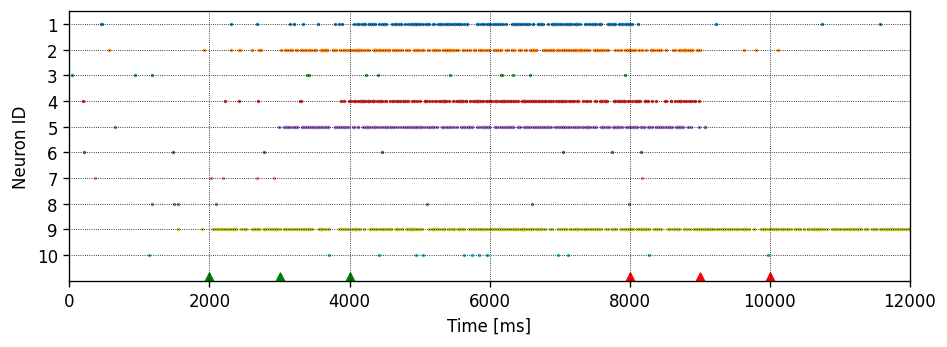

In [13]:
# Plot the spiking activity
plot_spiking_activity(neuron_spike_times, pos_dopa_spike_times, neg_dopa_spike_times, source_ids, sim_time)

From the spiking activity of the neurons, we can see that the firing rate of the neurons increases after the dopamine spikes or reward signals (green triangles in the plot) are applied to the synapses. Consequently, when the punishment signals are applied (red triangles), the firing rate decreases. In order to understand the dynamics, let's plot the different trace variables of the synapse.

### Plot the trace values

Let's plot the trace values and the weight for each synapse. Note that the dopamine trace is the same for every synapse.

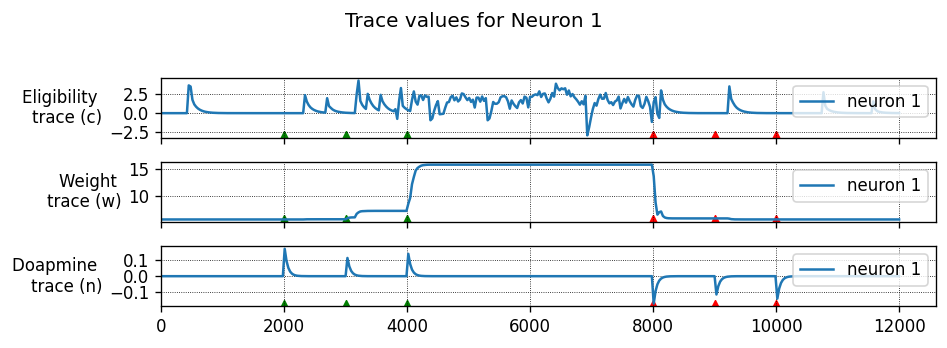

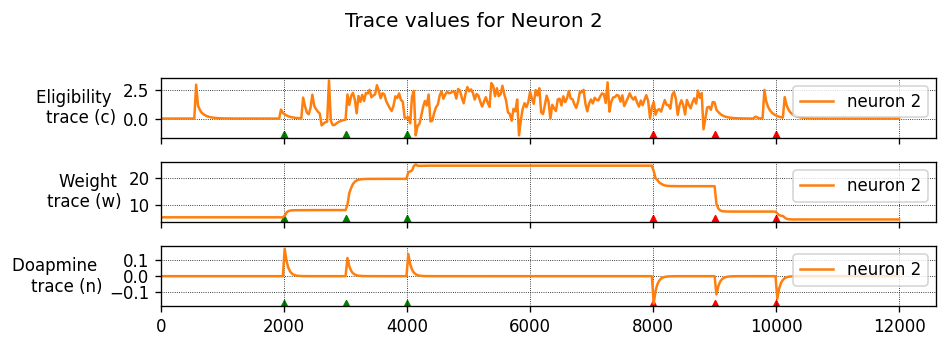

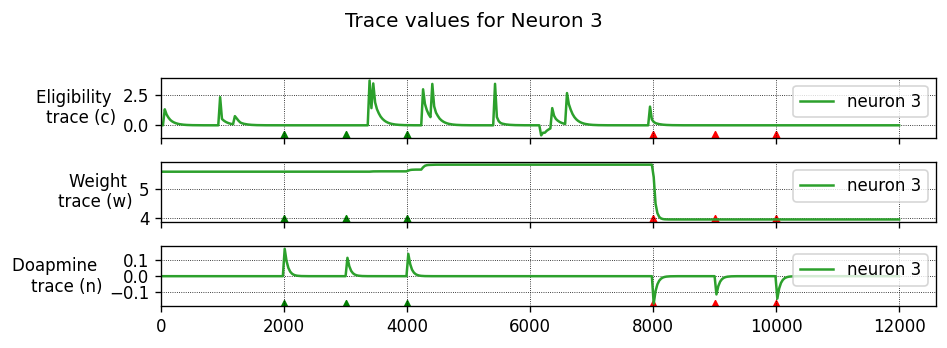

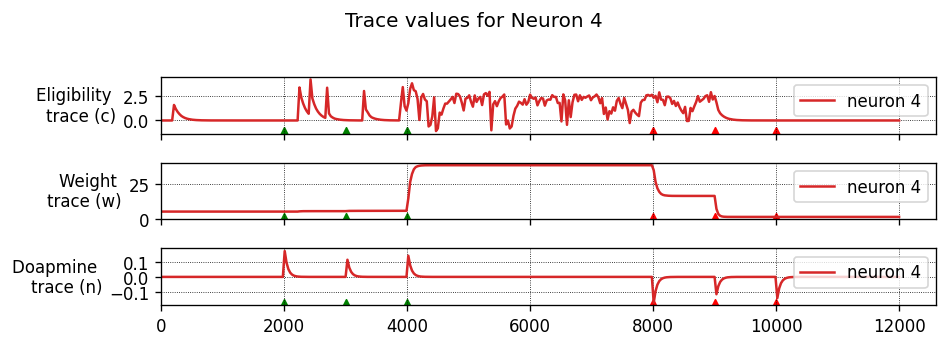

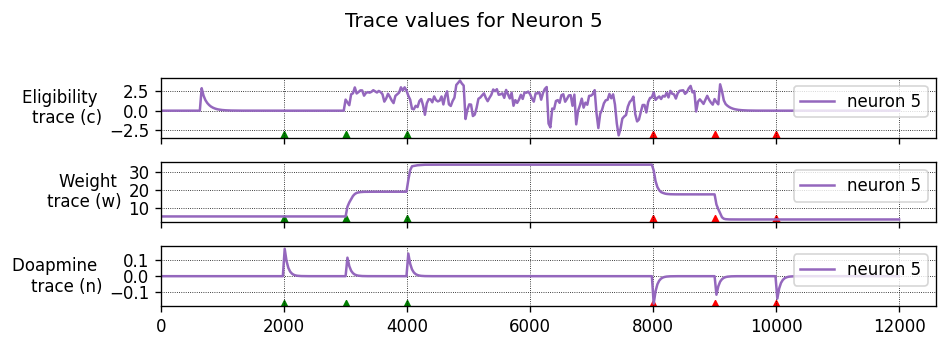

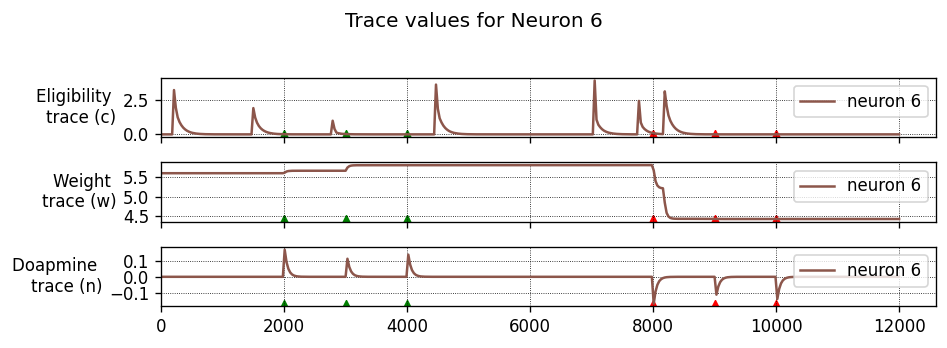

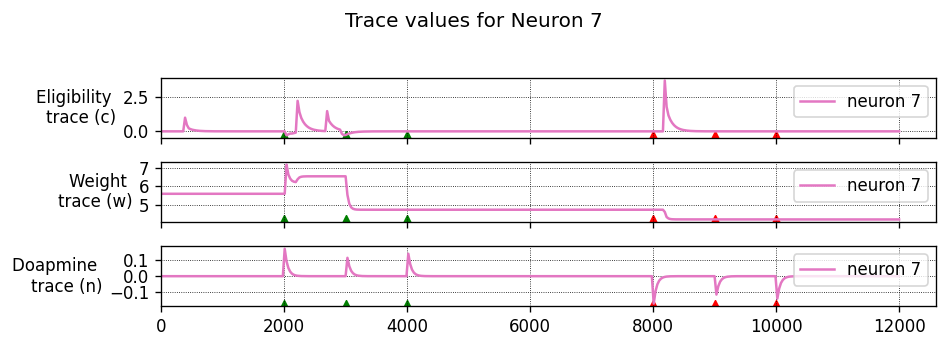

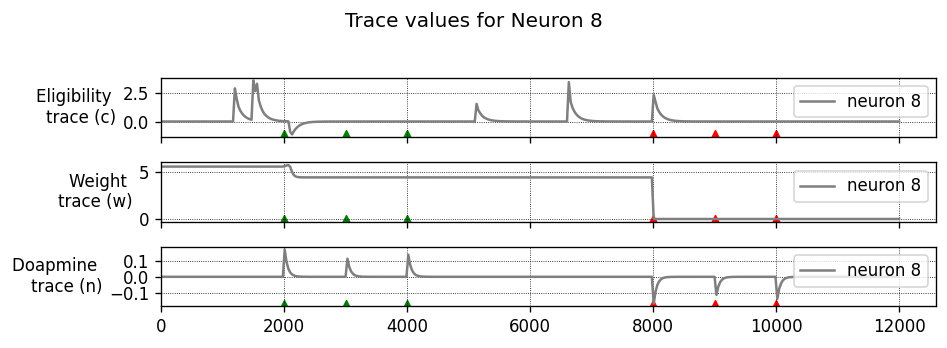

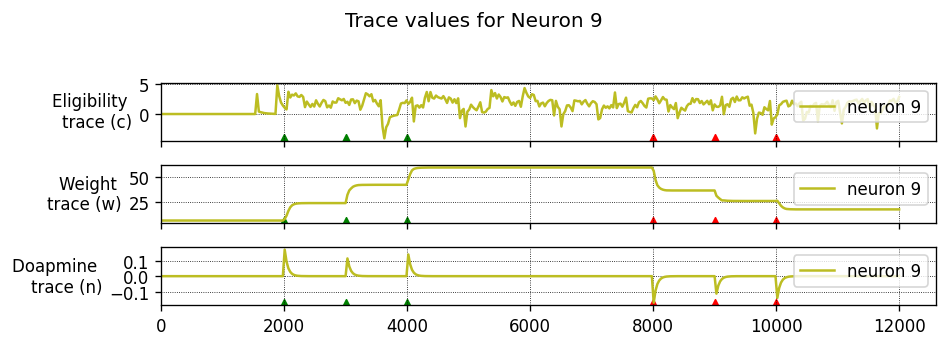

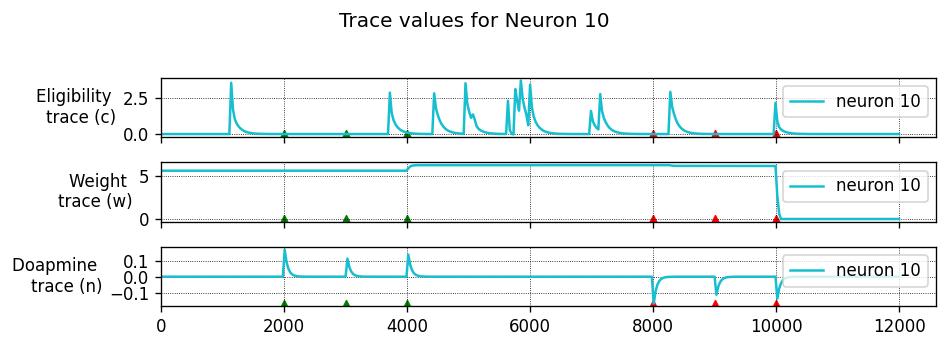

In [14]:
# Plot trace values for all neurons
plot_traces_for_neuron(log, ["c", "w", "n"], pos_dopa_spike_times=pos_dopa_spike_times, neg_dopa_spike_times=neg_dopa_spike_times)

As we can see, the eligibility trace values for neurons 1, 2, 4, 5, and 9 are large when the dopamine spikes are applied, which increases the weights of these neurons, resulting in stronger firing. If the dopamine spikes arrive while the eligibility trace is close to zero, the weight does not increase or increases only very little.
 
In our simulation above, we set a low value of 50 ms for the time constant of the dopamine trace $\tau_n$. This means that the dopamine signal does not sustain for a long time, allowing only some neurons that fire around the time when the dopamine spikes (reward signal) are applied have their synapses strengthened (see the weight trace plots) and consequenty increase their firing rate. Similarly, the firing rate is decreased when the dopamine spikes (punishment signals) are applied. For neuron 9, the punishment signal doesn't seem to affect the firing rate. This behavior can be explained by the time constant of the signals and the very large weights after the initial potentiation, resulting in sustained firing.

Play around with the initial weight value `w` and dopamine time constant $\tau_n$ to simulate and see the effects of these values on firing rates and trace values.

## Noisy Cue-Association: Temporal Credit-Assignment Task

In this experiment, the synapse is embedded in a network consisting of 800 excitatory, and 200 inhibitory neurons, that are randomly and sparsely connected. The network is in the _balanced state_, meaning that excitatory currents are roughly matched in mean amplitude over time, and the neurons have a membrane potential close to the firing threshold, firing only sparsely and with statistics approaching that of a Poisson process [4].

Using this network, we illustrate a classical (Pavlovian) conditioning experiment: rewarding a conditioned stimulus $S_1$ embedded in a continuous stream of irrelevant but equally salient stimuli [3]. The conditioned stimulus is repeatedly presented to the network, causing a transient of activity against the background of low-rate random background firing. The CS is always followed by a reward, which reinforces the recurrent excitatory pathways in the network.

To simulate the experiment, `n_subgroups` random sets of neurons (each representing stimulus $S_1$ through $S_\text{n\_subgroups}$) are chosen from the pool of excitatory and inhibitory neurons in the network. To present a stimulus to the network, we create `n_subgroups` spike generators (named `stim_sg`), and connect each to its individual target group of `subgroup_size` neurons in the network (here, 50) with a very large weight, so that the stimulus spike generator firing will cause all of the neurons in the subgroup to fire.

A continuous input stream is generated, consisting of stimuli $S_i (1 \leq i \leq \text{n\_subgroups})$ in a random order with random intervals of rate `stimulus_rate` and at least `min_stimulus_presentation_delay`. After every presentation of the CS ($S_1$), a reward in the form of an increase of extra-cellular dopamine is delivered to all plastic synapses in the network, after a random delay between `min_dopa_reinforcement_delay` and `max_dopa_reinforcement_delay`. These delays were chosen lower than in the original publications ([1], [3]) to keep the simulation times low for this interactive tutorial. The delay is large enough to allow irrelevant input stimuli to be presented during the waiting period; these can be considered as distractors.

At the beginning of the experiment the neurons representing each stimulus $S_i$ respond equally. However, after many trials, the network starts to show reinforced response to the CS ($S_1$). Because synapses coming out of neurons representing $S_1$ are always tagged with the eligibility trace when the reward is delivered, whereas the synapses connected to neurons representing irrelevant stimuli will only be occasionally tagged, the average strength of synaptic connections from neurons representing stimulus $S_1$ becomes stronger than the mean synaptic connection strength in the rest of the network. Therefore, the other neurons in the network learn to listen more closely to the stimulus $S_1$, because the activation of this pathway causes a reward.


<div style="transform: scale(.8)">

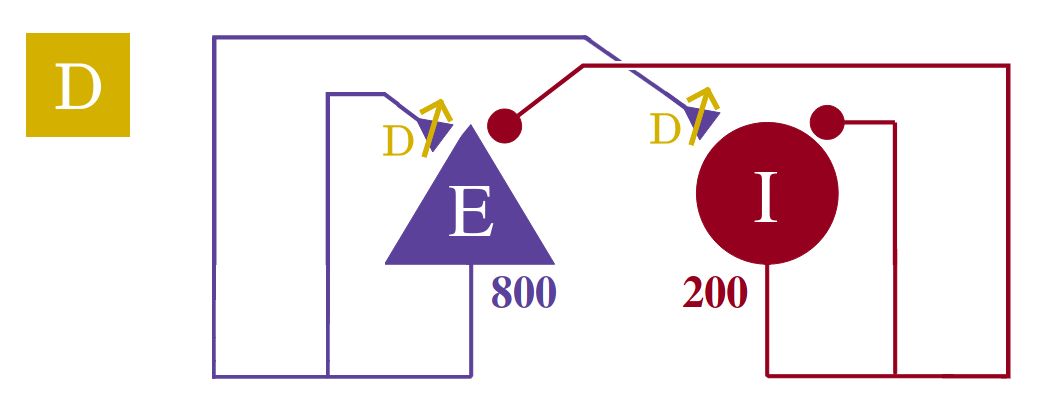

</div>

This network uses neurons with a decaying-exponential shaped postsynaptic current. Let's first generate the code for those.

In [15]:
# generate and build code


module_name, neuron_model_name, synapse_model_name = NESTCodeGeneratorUtils.generate_code_for("../../../models/neurons/iaf_psc_exp.nestml",
                                                                                                    nestml_stdp_dopa_model,
                                                                                                    post_ports=["post_spikes"],
                                                                                                    mod_ports=["mod_spikes"])

# load dynamic library (NEST extension module) into NEST kernel
nest.ResetKernel()
nest.Install(module_name)

[11,neuromodulated_stdp6e6abce83c944886bd3262e4ea77c799_nestml, WARNING, [12:8;12:28]]: Variable 'd' has the same name as a physical unit!
[21,neuromodulated_stdp6e6abce83c944886bd3262e4ea77c799_nestml, WARNING, [12:8;12:28]]: Variable 'd' has the same name as a physical unit!
[43,neuromodulated_stdp6e6abce83c944886bd3262e4ea77c799_nestml__with_iaf_psc_exp6e6abce83c944886bd3262e4ea77c799_nestml, WARNING, [12:8;12:28]]: Variable 'd' has the same name as a physical unit!


[56,neuromodulated_stdp6e6abce83c944886bd3262e4ea77c799_nestml__with_iaf_psc_exp6e6abce83c944886bd3262e4ea77c799_nestml, WARNING, [12:8;12:28]]: Variable 'd' has the same name as a physical unit!
[60,neuromodulated_stdp6e6abce83c944886bd3262e4ea77c799_nestml__with_iaf_psc_exp6e6abce83c944886bd3262e4ea77c799_nestml, WARNING, [12:8;12:28]]: Variable 'd' has the same name as a physical unit!


Now, we define the network and the simulation parameters.

In [16]:
# simulation parameters

dt = .1    # the resolution in ms
delay = 1.    # synaptic delay in ms
total_t_sim = 10000.  # [ms]

# parameters for balanced network

g = 4.  # ratio inhibitory weight/excitatory weight
epsilon = .1  # connection probability
NE = 800  # number of excitatory neurons
NI = 200  # number of inhibitory neurons
N_neurons = NE + NI   # number of neurons in total
N_rec = 50      # record from 50 neurons

CE = int(epsilon * NE)  # number of excitatory synapses per neuron
CI = int(epsilon * NI)  # number of inhibitory synapses per neuron
C_tot = int(CI + CE)      # total number of synapses per neuron

# neuron parameters

tauSyn = 1.  # synaptic time constant [ms]
tauMem = 10.  # time constant of membrane potential [ms]
CMem = 300.  # capacitance of membrane [pF]

neuron_params_exc = {"C_m": CMem,
                 "tau_m": tauMem,
                 "tau_syn_exc": tauSyn,
                 "tau_syn_inh": tauSyn,
                 "t_ref": 4.0,
                 "E_L": -65.,
                 "V_reset": -70.,
                 "V_m": -65.,
                 "V_th": -55.4,
                 "I_e": 0.   # [pA]
}
neuron_params_inh = {"C_m": CMem,
                 "tau_m": tauMem,
                 "tau_syn_exc": tauSyn,
                 "tau_syn_inh": tauSyn,
                 "t_ref": 2.0,
                 "E_L": -65.,
                 "V_reset": -70.,
                 "V_m": -65.,
                 "V_th": -56.4}

# J_ex should be large enough so that when stimulus excites the subgroup cells,
# the subgroup cells cause an excitatory transient in the network to establish
# a causal STDP timing and positive eligibility trace in the synapses
J_ex = 300.  # amplitude of excitatory postsynaptic current
J_in = -g * J_ex    # amplitude of inhibitory postsynaptic current
J_poisson = 2500.
J_stim = 5000.

p_rate = 5.    # external Poisson generator rate [s^-1]

# synapse parameters

learning_rate = .1   # multiplier for weight updates
tau_c = 200.  # [ms]
tau_n = 200.  # [ms]

# stimulus parameters

n_subgroups = 2  # = n_stimuli
subgroup_size = 50   # per subgroup, this many neurons are stimulated when stimulus is presented
reinforced_subgroup_idx = 0
stimulus_rate = 5.   # [s^-1]

min_stimulus_presentation_delay = 10.   # minimum time between presenting stimuli [ms]

min_dopa_reinforcement_delay = 10. # [ms]
max_dopa_reinforcement_delay = 30. # [ms]

With the parameters defined, we are ready to instantiate and connect the network.

In [17]:
nest.ResetKernel()
nest.set_verbosity("M_ALL")
nest.local_num_threads = 4

nest.resolution = dt
nest.print_time = True
nest.overwrite_files = True

nodes_ex = nest.Create(neuron_model_name, NE, params=neuron_params_exc)
nodes_in = nest.Create(neuron_model_name, NI, params=neuron_params_inh)
noise = nest.Create("poisson_generator", params={"rate": p_rate})
vt_spike_times = []
vt_sg = nest.Create("spike_generator",
                    params={"spike_times": vt_spike_times,
                            "allow_offgrid_times": True})

espikes = nest.Create("spike_recorder")
ispikes = nest.Create("spike_recorder")
spikedet_vt = nest.Create("spike_recorder")

# create volume transmitter
vt = nest.Create("volume_transmitter")
vt_parrot = nest.Create("parrot_neuron")
nest.Connect(vt_sg, vt_parrot)
nest.Connect(vt_parrot, vt, syn_spec={"synapse_model": "static_synapse",
                                      "weight": 1.,
                                      "delay": 1.})   # delay is ignored
# set up custom synapse models
wr = nest.Create("weight_recorder")
nest.CopyModel(synapse_model_name, "excitatory",
               {"weight_recorder": wr, "w": J_ex, "d": delay, "receptor_type": 0,
                "volume_transmitter": vt, "A_plus": learning_rate * 1., "A_minus": learning_rate * 1.5,
               "tau_n": tau_n,
               "tau_c": tau_c})

nest.CopyModel("static_synapse", "inhibitory",
               {"weight": J_in, "delay": delay})
nest.CopyModel("static_synapse", "poisson",
               {"weight": J_poisson, "delay": delay})

# make subgroups: pick from excitatory population. subgroups can overlap, but
# each group consists of `subgroup_size` unique neurons

subgroup_indices = n_subgroups * [[]]
for i in range(n_subgroups):
    ids_nonoverlapping = False
    # TODO: replace while loop with:
    # subgroup_indices[i] = np.sort(np.random.choice(NE, size=subgroup_size, replace=False))
    while not ids_nonoverlapping:
        ids = np.random.randint(0, NE, subgroup_size)
        ids_nonoverlapping = len(np.unique(ids)) == subgroup_size
    ids.sort()
    subgroup_indices[i] = ids
    
# make one spike generator and one parrot neuron for each subgroup
stim_sg = nest.Create("spike_generator", n_subgroups)
stim_parrots = nest.Create("parrot_neuron", n_subgroups)

# make recording devices
stim_spikes_rec = nest.Create("spike_recorder")
mm = nest.Create("multimeter", params={'record_from': ['V_m'], 'interval': dt})
mms = [nest.Create("multimeter", params={'record_from': ['V_m'], 'interval': dt}) for _ in range(10)]

# connect everything up
nest.Connect(stim_parrots, stim_spikes_rec, syn_spec="static_synapse")
nest.Connect(noise, nodes_ex + nodes_in, syn_spec="poisson")
nest.Connect(mm, nodes_ex[0])
[nest.Connect(mms[i], nodes_ex[i]) for i in range(10)]

nest.Connect(stim_sg, stim_parrots, "one_to_one")

for i in range(n_subgroups):
    nest.Connect(stim_parrots[i], nodes_ex[subgroup_indices[i]], "all_to_all", syn_spec={"weight": J_stim})

conn_params_ex = {'rule': 'fixed_indegree', 'indegree': CE}
nest.Connect(nodes_ex, nodes_ex + nodes_in, conn_params_ex, "excitatory")

conn_params_in = {'rule': 'fixed_indegree', 'indegree': CI}
nest.Connect(nodes_in, nodes_ex + nodes_in, conn_params_in, "inhibitory")

nest.Connect(vt_parrot, spikedet_vt)

nest.Connect(nodes_ex, espikes, syn_spec="static_synapse")
nest.Connect(nodes_in, ispikes, syn_spec="static_synapse")

# generate stimulus timings (input stimulus and reinforcement signal)

t_dopa_spikes = []
t_pre_sg_spikes = [[] for _ in range(n_subgroups)]   # mapping from subgroup_idx to a list of spike (or presentation) times of that subgroup

t = 0.   # [ms]
ev_timestamps = []
while t < total_t_sim:
    # jump to time of next stimulus presentation
    dt_next_stimulus = max(min_stimulus_presentation_delay, np.round(random.expovariate(stimulus_rate) * 1000)) # [ms]
    t += dt_next_stimulus

    ev_timestamps.append(t)
    
    # apply stimulus
    subgroup_idx = np.random.randint(0, n_subgroups)
    t_pre_sg_spikes[subgroup_idx].append(t)

    # reinforce?
    if subgroup_idx == reinforced_subgroup_idx:
        # fire a dopa spike some time after the current time
        t_dopa_spike = t + min_dopa_reinforcement_delay + np.random.randint(max_dopa_reinforcement_delay - min_dopa_reinforcement_delay)
        t_dopa_spikes.append(t_dopa_spike)

print("--> Stimuli will be presented at times: " + str(ev_timestamps))
        
# set the spike times in the spike generators
for i in range(n_subgroups):
    t_pre_sg_spikes[i].sort()
    stim_sg[i].spike_times = t_pre_sg_spikes[i]

t_dopa_spikes.sort()
vt_sg.spike_times = t_dopa_spikes

print("--> t_dopa_spikes = " + str(t_dopa_spikes))

--> Stimuli will be presented at times: [123.0, 142.0, 262.0, 487.0, 680.0, 733.0, 840.0, 978.0, 1004.0, 1230.0, 1867.0, 2061.0, 2163.0, 2505.0, 2764.0, 3102.0, 3195.0, 3770.0, 3780.0, 4008.0, 4054.0, 4420.0, 4450.0, 4767.0, 5080.0, 5688.0, 5949.0, 5959.0, 5986.0, 5996.0, 6515.0, 6663.0, 6685.0, 6766.0, 6816.0, 6875.0, 7151.0, 7395.0, 7501.0, 7896.0, 7935.0, 8246.0, 8260.0, 8553.0, 8739.0, 8852.0, 8984.0, 9068.0, 9200.0, 9329.0, 9693.0, 9959.0, 10227.0]
--> t_dopa_spikes = [283.0, 513.0, 863.0, 1022.0, 1245.0, 1883.0, 2082.0, 2785.0, 3207.0, 3789.0, 3802.0, 4037.0, 4081.0, 4462.0, 4787.0, 5998.0, 6536.0, 6705.0, 6784.0, 6839.0, 7178.0, 8267.0, 8286.0, 8573.0, 8757.0, 8876.0, 9090.0, 9352.0, 10256.0]


Run the simulation. Instead of just running from start to finish in one go:

In [18]:
# nest.Simulate(total_t_sim)

we split the simulation into equally-sized chunks, so that we can measure and record the state of some internal variables inbetween:

In [19]:
def run_chunked_simulation(n_chunks, all_nodes, reinforced_group_nodes, not_reinforced_group_nodes):
    # init log
    log = {}
    log["t"] = []
    log["w_net"] = []
    recordables = ["c_sum", "w_avg", "n_avg"]
    for group in ["reinforced_group", "not_reinforced_group"]:
        log[group] = {}
        for recordable in recordables:
            log[group][recordable] = []
    
    nest.Prepare()
    for i in range(n_chunks):
        print(str(np.round(100 * i / n_chunks)) + "%")

        # simulate one chunk
        nest.Run(total_t_sim // n_chunks)

        # log current values
        log["t"].append(nest.GetKernelStatus("biological_time"))

        syn_reinforced_subgroup = nest.GetConnections(source=reinforced_group_nodes, synapse_model="excitatory")
        syn_nonreinforced_subgroup = nest.GetConnections(source=not_reinforced_group_nodes, synapse_model="excitatory")
        syn_all = nest.GetConnections(source=all_nodes, synapse_model="excitatory")

        log["w_net"].append(np.mean(syn_all.w))

        log["reinforced_group"]["w_avg"].append(np.mean(syn_reinforced_subgroup.get("w")))
        log["not_reinforced_group"]["w_avg"].append(np.mean(syn_nonreinforced_subgroup.get("w")))

        log["reinforced_group"]["c_sum"].append(np.sum(syn_reinforced_subgroup.get("c")))
        log["not_reinforced_group"]["c_sum"].append(np.sum(syn_nonreinforced_subgroup.get("c")))

        log["reinforced_group"]["n_avg"].append(np.mean(syn_reinforced_subgroup.get("n")))
        log["not_reinforced_group"]["n_avg"].append(np.mean(syn_nonreinforced_subgroup.get("n")))
    nest.Cleanup()

    return log

In [20]:
all_nodes = nodes_ex
reinforced_group_nodes = nodes_ex[subgroup_indices[reinforced_subgroup_idx]]
not_reinforced_group_nodes = nodes_ex[subgroup_indices[1 - reinforced_subgroup_idx]]

n_chunks = 100

log = run_chunked_simulation(n_chunks,
                             all_nodes,
                             reinforced_group_nodes,
                             not_reinforced_group_nodes)

0.0%
1.0%
2.0%
3.0%
4.0%
5.0%
6.0%
7.0%
8.0%
9.0%
10.0%
11.0%
12.0%
13.0%
14.0%
15.0%
16.0%
17.0%
18.0%
19.0%
20.0%
21.0%
22.0%
23.0%
24.0%
25.0%
26.0%
27.0%
28.0%
29.0%
30.0%
31.0%
32.0%
33.0%
34.0%
35.0%
36.0%
37.0%
38.0%
39.0%
40.0%
41.0%
42.0%
43.0%
44.0%
45.0%
46.0%
47.0%
48.0%
49.0%
50.0%
51.0%
52.0%
53.0%
54.0%
55.0%
56.0%
57.0%
58.0%
59.0%
60.0%
61.0%
62.0%
63.0%
64.0%
65.0%
66.0%
67.0%
68.0%
69.0%
70.0%
71.0%
72.0%
73.0%
74.0%
75.0%
76.0%
77.0%
78.0%
79.0%
80.0%
81.0%
82.0%
83.0%
84.0%
85.0%
86.0%
87.0%
88.0%
89.0%
90.0%
91.0%
92.0%
93.0%
94.0%
95.0%
96.0%
97.0%
98.0%
99.0%


Print some network statistics:

In [21]:
events_ex = espikes.n_events
events_in = ispikes.n_events

rate_ex = events_ex / total_t_sim * 1000.0 / N_rec
rate_in = events_in / total_t_sim * 1000.0 / N_rec

num_synapses = (nest.GetDefaults("excitatory")["num_connections"] +
                nest.GetDefaults("inhibitory")["num_connections"])

print("Balanced network simulation statistics:")
print(f"Number of neurons : {N_neurons}")
print(f"Number of synapses: {num_synapses}")
print(f"       Exitatory  : {int(CE * N_neurons) + N_neurons}")
print(f"       Inhibitory : {int(CI * N_neurons)}")
print(f"Excitatory rate   : {rate_ex:.2f} Hz")
print(f"Inhibitory rate   : {rate_in:.2f} Hz")
print("Actual times of stimulus presentation: " + str(stim_spikes_rec.events["times"]))
print("Actual t_dopa_spikes = " + str(spikedet_vt.get("events")["times"]))


Balanced network simulation statistics:
Number of neurons : 1000
Number of synapses: 100000
       Exitatory  : 81000
       Inhibitory : 20000
Excitatory rate   : 12.43 Hz
Inhibitory rate   : 3.00 Hz
Actual times of stimulus presentation: [ 124.  143.  681.  734.  979. 2164. 2506. 3103. 4421. 5081. 5689. 5950.
 5960. 5997. 6664. 6876. 7396. 7502. 7897. 7936. 8985. 9201. 9694. 9960.
  263.  488.  841. 1005. 1231. 1868. 2062. 2765. 3196. 3771. 3781. 4009.
 4055. 4451. 4768. 5987. 6516. 6686. 6767. 6817. 7152. 8247. 8261. 8554.
 8740. 8853. 9069. 9330.]
Actual t_dopa_spikes = [ 284.  514.  864. 1023. 1246. 1884. 2083. 2786. 3208. 3790. 3803. 4038.
 4082. 4463. 4788. 5999. 6537. 6706. 6785. 6840. 7179. 8268. 8287. 8574.
 8758. 8877. 9091. 9353.]


### Rasterplot of network activity

N.B. orange diamonds indicate dopamine spikes.

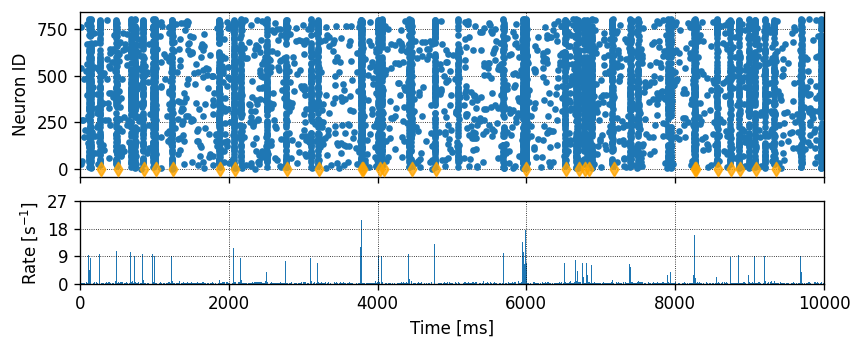

In [22]:
def _histogram(a, bins=10, bin_range=None, normed=False):
    """Calculate histogram for data.

    Parameters
    ----------
    a : list
        Data to calculate histogram for
    bins : int, optional
        Number of bins
    bin_range : TYPE, optional
        Range of bins
    normed : bool, optional
        Whether distribution should be normalized

    Raises
    ------
    ValueError
    """
    from numpy import asarray, iterable, linspace, sort, concatenate

    a = asarray(a).ravel()

    if bin_range is not None:
        mn, mx = bin_range
        if mn > mx:
            raise ValueError("max must be larger than min in range parameter")

    if not iterable(bins):
        if bin_range is None:
            bin_range = (a.min(), a.max())
        mn, mx = [mi + 0.0 for mi in bin_range]
        if mn == mx:
            mn -= 0.5
            mx += 0.5
        bins = linspace(mn, mx, bins, endpoint=False)
    else:
        if (bins[1:] - bins[:-1] < 0).any():
            raise ValueError("bins must increase monotonically")

    # best block size probably depends on processor cache size
    block = 65536
    n = sort(a[:block]).searchsorted(bins)
    for i in range(block, a.size, block):
        n += sort(a[i:i + block]).searchsorted(bins)
    n = concatenate([n, [len(a)]])
    n = n[1:] - n[:-1]

    if normed:
        db = bins[1] - bins[0]
        return 1.0 / (a.size * db) * n, bins
    else:
        return n, bins

ev = espikes.get("events")
ts, node_ids = ev["times"], ev["senders"]
hist_binwidth = 10. # [ms]
    
fig, ax = plt.subplots(nrows=2, gridspec_kw={"height_ratios": (2, 1)})
ax[0].plot(ts, node_ids, ".")
ax[0].scatter(t_dopa_spikes, np.zeros_like(t_dopa_spikes), marker="d", c="orange", alpha=.8, zorder=99)
ax[0].set_ylabel("Neuron ID")

t_bins = np.arange(
    np.amin(ts), np.amax(ts),
    float(hist_binwidth)
)
n, _ = _histogram(ts, bins=t_bins)
num_neurons = len(np.unique(node_ids))
heights = 1000 * n / (hist_binwidth * num_neurons)
ax[1].bar(t_bins, heights, width=hist_binwidth, color="tab:blue", edgecolor="none")
ax[1].set_yticks([
    int(x) for x in
    np.linspace(0, int(max(heights) * 1.1) + 5, 4)
])
ax[1].set_ylabel("Rate [s${}^{-1}$]")
ax[0].set_xticklabels([])
ax[-1].set_xlabel("Time [ms]")
for _ax in ax:
    _ax.set_xlim(0., total_t_sim)

### Plot membrane potential of 10 random excitatory cells

This helps to check if the network is in a balanced excitation/inhibition regime.

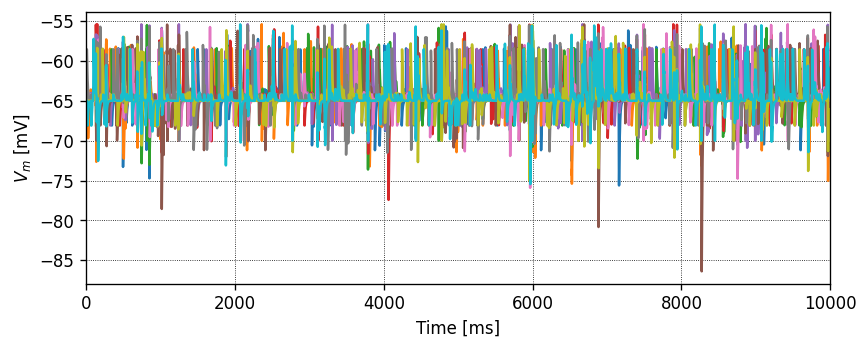

In [23]:
fig, ax = plt.subplots()
for i in range(10):
    ax.plot(mms[i].get("events")["times"], mms[i].get("events")["V_m"], label="V_m")
ax.set_xlim(0., total_t_sim)
ax.set_ylabel("$V_m$ [mV]")
ax.set_xlabel("Time [ms]")

None

### Timeseries

We should verify that the dopamine concentration is the same in group and nongroup neurons.

Note that the timeseries resolution (due to the chunking of the simulation) could be too low to see fast dopamine dynamics. Use more chunks to increase the temporal resolution of this plot, or fewer to speed up the simulation. Consider the relationship between $\tau_d$ and how many chunks we need to adequately visualize the dynamics.

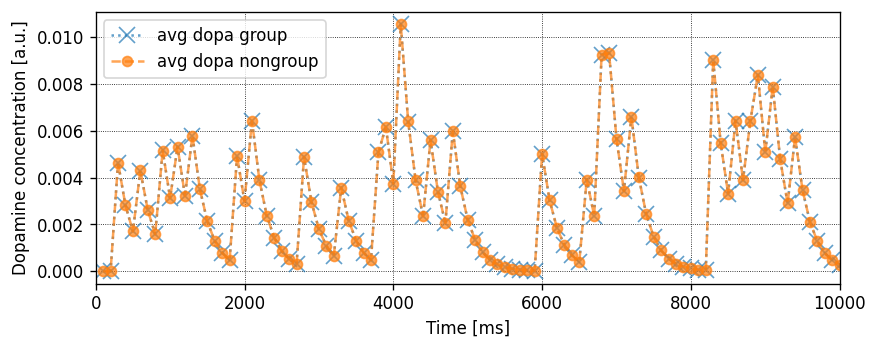

In [24]:
fig,ax = plt.subplots()

ax.plot(log["t"], log["reinforced_group"]["n_avg"], label="avg dopa group", linestyle=":", markersize=10, alpha=.7, marker="x")
ax.plot(log["t"], log["not_reinforced_group"]["n_avg"], label="avg dopa nongroup", linestyle="--", alpha=.7, marker="o")
ax.legend()

ax.set_xlim(0., total_t_sim)
ax.set_xlabel("Time [ms]")
ax.set_ylabel("Dopamine concentration [a.u.]")

None

In any case, all synapses seem to be receiving the same dopamine signal.

Now plot the average eligibility trace $c$ for group and nongroup neurons:

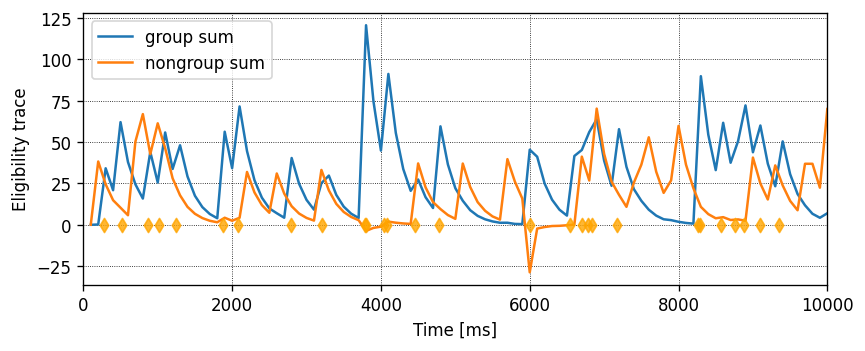

In [25]:
fig,ax = plt.subplots(figsize=(8, 3))
ax.plot(log["t"], log["reinforced_group"]["c_sum"], label="group sum")
ax.plot(log["t"], log["not_reinforced_group"]["c_sum"], label="nongroup sum")
ax.scatter(t_dopa_spikes, np.zeros_like(t_dopa_spikes), marker="d", c="orange", alpha=.8, zorder=99)
ax.set_xlim(0., total_t_sim)
ax.set_xlabel("Time [ms]")
ax.set_ylabel("Eligibility trace")
ax.legend()

None

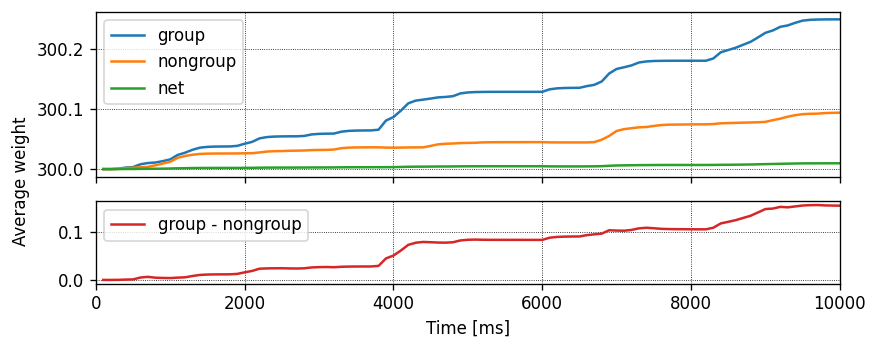

In [26]:
fig,ax = plt.subplots(nrows=2, gridspec_kw={"height_ratios": (2, 1)})

ax[0].plot(log["t"], log["reinforced_group"]["w_avg"], label="group")
ax[0].plot(log["t"], log["not_reinforced_group"]["w_avg"], label="nongroup")
ax[0].plot(log["t"], log["w_net"], label="net")
ax[1].plot(log["t"], np.array(log["reinforced_group"]["w_avg"]) - np.array(log["not_reinforced_group"]["w_avg"]),
           label="group - nongroup", c="tab:red")
for _ax in ax:
    _ax.legend()
    _ax.set_xlim(0., total_t_sim)

ax[-1].set_xlabel("Time [ms]")
ax[0].set_xticklabels([])
ax[0].set_ylabel("Average weight                                                                     ")

None

We can also plot all `subgroup_size` weights over time for the reinforced and non-reinforced groups as a scatterplot.

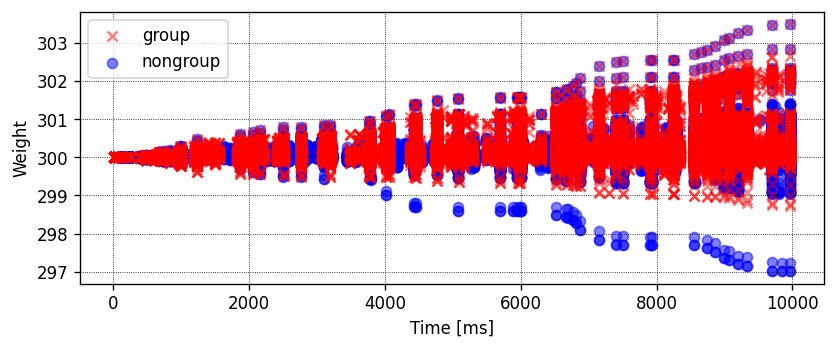

In [27]:
 group_weight_times = [[] for _ in range(n_subgroups)]
group_weight_values = [[] for _ in range(n_subgroups)]
                                        
senders = np.array(wr.events["senders"])

for subgroup_idx in range(n_subgroups):
    nodes_ex_gids = nodes_ex[subgroup_indices[subgroup_idx]].tolist()
    idx = [np.where(senders == nodes_ex_gids[i])[0] for i in range(subgroup_size)]
    idx = [item for sublist in idx for item in sublist]
    group_weight_times[subgroup_idx] = wr.events["times"][idx]
    group_weight_values[subgroup_idx] = wr.events["weights"][idx]

fig, ax = plt.subplots()
for subgroup_idx in range(n_subgroups):
    if subgroup_idx == reinforced_subgroup_idx:
        c = "red"
        zorder = 99
        marker = "x"
        label = "group"
    else:
        c = "blue"
        zorder=1
        marker = "o"
        label = "nongroup"
        
    ax.scatter(group_weight_times[subgroup_idx], group_weight_values[subgroup_idx], c=c, alpha=.5, zorder=zorder, marker=marker, label=label)

ax.set_ylabel("Weight")
ax.set_xlabel("Time [ms]")
ax.legend()

None

# Citations
---------

[1] Mikaitis M, Pineda García G,
Knight JC and Furber SB (2018)
Neuromodulated Synaptic Plasticity
on the SpiNNaker Neuromorphic
System. Front. Neurosci. 12:105.
doi: 10.3389/fnins.2018.00105

[2] PyGeNN: A Python library for GPU-enhanced neural networks, James C. Knight, Anton Komissarov, Thomas Nowotny. Frontiers

[3] Eugene M. Izhikevich. Solving the distal reward problem through linkage of STDP and dopamine signaling. Cerebral Cortex 17, no. 10 (2007): 2443-2452.

[4] Nicolas Brunel. Dynamics of sparsely connected networks of excitatory and inhibitory spiking neurons. Journal of Computational Neuroscience 8(3):183-208 (2000)


Acknowledgements
----------------

This software was developed in part or in whole in the Human Brain Project, funded from the European Union’s Horizon 2020 Framework Programme for Research and Innovation under Specific Grant Agreements No. 720270, No. 785907 and No. 945539 (Human Brain Project SGA1, SGA2 and SGA3).

The authors would like to thank James Knight, Garibaldi García and Mantas Mikaitis for their kind and helpful feedback.


License
-------

This notebook (and associated files) is free software: you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation, either version 2 of the License, or (at your option) any later version.

This notebook (and associated files) is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details.